<a href="https://colab.research.google.com/github/kishore-n-george/tabular-llm-comparison/blob/main/Dataset_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
#python3 -m venv tabular
#!pip install jupyter numpy pandas scikit-learn xgboost torch transformers shap scikit-learn seaborn matplotlib ucimlrepo xgboost tabpfn rtdl torch lime folium eli5
# torchvision torchaudio
# ft_transformer

#linear algebra
import numpy as np 
import math

#data tools
from copy import copy
import pandas as pd
from scipy.stats import boxcox
from scipy.special import boxcox1p
from scipy.special import inv_boxcox
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from IPython.display import Image

#plots
import seaborn as sns
import matplotlib.pyplot as plt

#models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor 

#model interpretation modules
import lime
import lime.lime_tabular
import shap
# import eli5

#metrics
from sklearn.metrics import mean_squared_error, r2_score

#awesome interactive map library
import folium
from folium.plugins import HeatMap
from folium.plugins import FastMarkerCluster

#statistics
from scipy import stats

#ucimlrepo
from ucimlrepo import fetch_ucirepo, dotdict

%matplotlib inline
sns.set_style("whitegrid")

In [7]:
# Define a function for loading datasets
def fetch_airbnb_dataset(file_path='./books/data/AB_NYC_2019.csv', dataset_name='AirBnb'):
    """Load dataset and print basic info."""
    try:
        data = pd.read_csv(file_path)
        print(f"{dataset_name} loaded successfully!\n")
        print(f"Dataset shape: {data.shape}\n")
        print(f"Columns:\n{data.columns.tolist()}\n")
        print(f"First 5 rows:\n{data.head()}\n")
        return data
    except Exception as e:
        print(f"Error loading {dataset_name}: {e}")
        return None

fetch_airbnb_dataset()

AirBnb loaded successfully!

Dataset shape: (48895, 16)

Columns:
['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

First 5 rows:
     id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth          

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


In [20]:
# Define a function for preprocessing
def preprocess_data(data, categorical_cols=None, scaling_cols=None):
    """Preprocess dataset: handle missing values, encode categories, scale numeric data."""
    # Handle missing values
    data = data.dropna()  # Drop rows with missing values for simplicity

    # One-hot encoding for categorical features
    if categorical_cols:
        data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

    # Scale numeric columns
    if scaling_cols:
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        data[scaling_cols] = scaler.fit_transform(data[scaling_cols])

    print("Data preprocessing complete.\n")
    print("Data shape after preprocessing")
    print(data.shape)
    return data



def perform_classification_eda(data, target_column):
    """Perform EDA for classification tasks: 
    - Summary statistics 
    - Distribution of the target variable 
    - Correlation heatmap 
    - Class distribution analysis 
    - Visualizing relationships between features and target
    """
    # Basic Statistics for numerical features
    print("Basic Statistics for Numerical Features:\n")
    print(data.describe().T)

    # Target variable distribution (class distribution)
    plt.figure(figsize=(8, 5))
    sns.countplot(x=target_column, data=data)
    plt.title(f"Class Distribution of {target_column}")
    plt.show()

    # If the target is categorical, plot a bar plot of counts
    if data[target_column].dtype == 'object' or len(data[target_column].unique()) < 20:
        plt.figure(figsize=(8, 5))
        sns.countplot(x=target_column, data=data)
        plt.title(f"Class Distribution of {target_column}")
        plt.show()
    
    # Explore relationship between numerical features and target variable
    numerical_features = data.select_dtypes(include=['float64', 'int64']).columns
    for feature in numerical_features:
        plt.figure(figsize=(8, 5))
        sns.boxplot(x=target_column, y=feature, data=data)
        plt.title(f"{feature} vs {target_column}")
        plt.show()

    # Explore correlation between numerical features
    plt.figure(figsize=(12, 8))
    corr = data[numerical_features].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", mask=np.triu(corr))
    plt.title("Correlation Matrix (Numerical Features)")
    plt.show()

    # Explore relationship between categorical features and target
    categorical_features = data.select_dtypes(include=['object']).columns
    for feature in categorical_features:
        plt.figure(figsize=(8, 5))
        sns.countplot(x=feature, hue=target_column, data=data)
        plt.title(f"{feature} vs {target_column}")
        plt.show()

    # If there are missing values
    missing_data = data.isnull().sum() / len(data) * 100
    missing_data = missing_data[missing_data > 0]

    if len(missing_data) > 0:
        print("\nMissing Data (%):")
        print(missing_data)
    else:
        print("\nNo missing data.")


# Define a function for exploratory data analysis
def perform_eda(data, target_column):
    """Perform basic EDA: print stats, plot distributions, and check correlations."""
    print("Basic Statistics:\n")
    print(data.describe().T)

    # Plot target variable distribution
    plt.figure(figsize=(8, 5))
    sns.histplot(data[target_column], kde=True, bins=30)
    plt.title(f"Distribution of {target_column}")
    plt.show()

    # Plot correlation heatmap
    plt.figure(figsize=(12, 8))
    corr = data.corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", mask=np.triu(corr))
    plt.title("Correlation Matrix")
    plt.show()

def get_all_datasets_dict():
  return {
      "Bike Sharing": dataframes["Bike Sharing"],
      "NYC Airbnb": dataframes["NYC Airbnb"],
      "Dry Bean": dataframes["Dry Bean"],
      "Online Shoppers": dataframes["Online Shoppers"]
        }



def process_all_datasets():
  # Paths to datasets (to be updated with actual paths)
  # Process each dataset
  dataframes = {}

  datasets = {
      #"Bike Sharing": {"id": 275, "is_classification": False}, # regression
      "NYC Airbnb": { "id": fetch_airbnb_dataset,"is_classification": False}, # regression
      #"Dry Bean": {"id": 602,"is_classification": True}, # classification
      #"Online Shoppers": {"id": 468, "is_classification": True },# classification
  }

  # Define target columns for each dataset
  target_columns = {
      #"Bike Sharing": "count",  # Replace with actual target column name
      "NYC Airbnb": "price",  # Replace with actual target column name
      #"Dry Bean": "Class",  # Replace with actual target column name
      #"Online Shoppers": "Revenue",  # Replace with actual target column name
  }


  for dataset_name, details in datasets.items():
      print(f"Processing {dataset_name} dataset...\n")
      if(isinstance(details["id"],int)):
        dataset = fetch_ucirepo(id=details["id"])
      else:
        dataset = details["id"]()
      if dataset is not None:
          if((isinstance(dataset, dotdict))):
            #data = data.data
            original = dataset.data.original
            target_col = dataset.metadata.target_col[0]
            print(target_col)
          else:
            original = dataset
            target_col = target_columns.get(dataset_name)


          # Identify categorical and scaling columns (to be refined per dataset)
          categorical_cols = original.select_dtypes(include=['object']).columns.tolist()
          scaling_cols = original.select_dtypes(include=['float64', 'int64']).columns.tolist()
          # Check if column exists and remove it
          if target_col in scaling_cols:
              scaling_cols.remove(target_col)  # Exclude target column from scaling
          if target_col in categorical_cols:
              categorical_cols.remove(target_col)  # Exclude target column from scaling

          # Preprocess data
          
          # processed_data = preprocess_data(original, categorical_cols, scaling_cols)
          

          # Perform EDA
          # if(details["is_classification"]):
          #   print("Classification EDA")
          #   perform_classification_eda(processed_data, target_col)
          # else:
          #   print("Regression EDA")
          #   perform_eda(processed_data, target_col)

          # Save processed dataframe
          dataframes[dataset_name] = original

  print("Dataset preparation completed for all datasets.")

  print(dataframes)

  return dataframes

processed_dataframes = process_all_datasets()

print("completed!!!!!!")

Processing NYC Airbnb dataset...

AirBnb loaded successfully!

Dataset shape: (48895, 16)

Columns:
['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

First 5 rows:
     id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73

In [19]:
for k in processed_dataframes.keys():
    print(f"printing {k}")
    print(processed_dataframes[k].describe().T)
    print(processed_dataframes[k].shape)

printing NYC Airbnb
                                  count        mean         std       min  \
latitude                        48895.0   40.728949    0.054530  40.49979   
longitude                       48895.0  -73.952170    0.046157 -74.24442   
price                           48895.0  152.720687  240.154170   0.00000   
minimum_nights                  48895.0    7.029962   20.510550   1.00000   
number_of_reviews               48895.0   23.274466   44.550582   0.00000   
reviews_per_month               38843.0    1.373221    1.680442   0.01000   
calculated_host_listings_count  48895.0    7.143982   32.952519   1.00000   
availability_365                48895.0  112.781327  131.622289   0.00000   

                                     25%        50%         75%          max  
latitude                        40.69010   40.72307   40.763115     40.91306  
longitude                      -73.98307  -73.95568  -73.936275    -73.71299  
price                           69.00000  106.000

AirBNB - XGBoost implementation

In [21]:
#!pip install torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score
import xgboost as xgb
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from tabpfn import TabPFNClassifier
from rtdl import FTTransformer
import shap

In [22]:
# Load Airbnb Dataset
airbnb = processed_dataframes["NYC Airbnb"]
print(airbnb)

# Data cleaning
# dropping unnecessary features
airbnb.drop('id', axis=1, inplace=True)
airbnb.drop('host_id', axis=1, inplace=True)
airbnb.drop('name', axis=1, inplace=True)
airbnb.drop('host_name', axis=1, inplace=True)

             id                                               name   host_id  \
0          2539                 Clean & quiet apt home by the park      2787   
1          2595                              Skylit Midtown Castle      2845   
2          3647                THE VILLAGE OF HARLEM....NEW YORK !      4632   
3          3831                    Cozy Entire Floor of Brownstone      4869   
4          5022   Entire Apt: Spacious Studio/Loft by central park      7192   
...         ...                                                ...       ...   
48890  36484665    Charming one bedroom - newly renovated rowhouse   8232441   
48891  36485057      Affordable room in Bushwick/East Williamsburg   6570630   
48892  36485431            Sunny Studio at Historical Neighborhood  23492952   
48893  36485609               43rd St. Time Square-cozy single bed  30985759   
48894  36487245  Trendy duplex in the very heart of Hell's Kitchen  68119814   

           host_name neighbourhood_grou

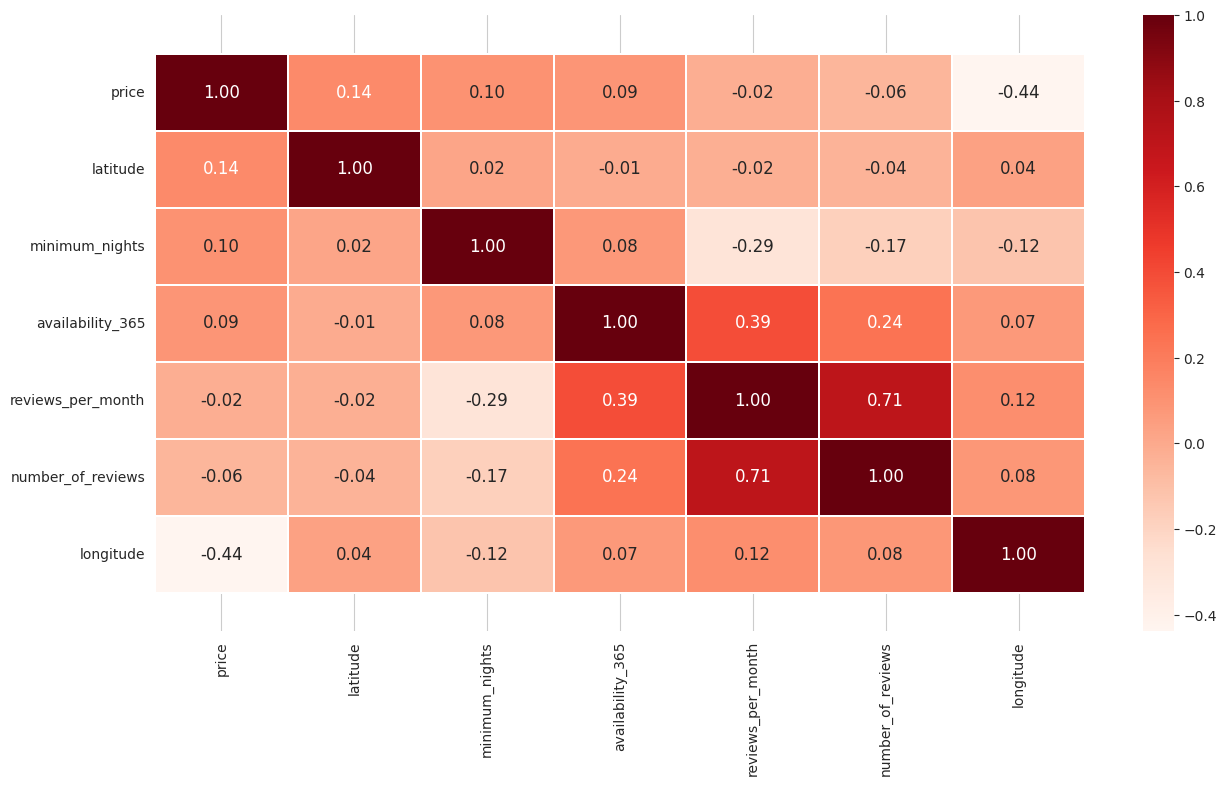

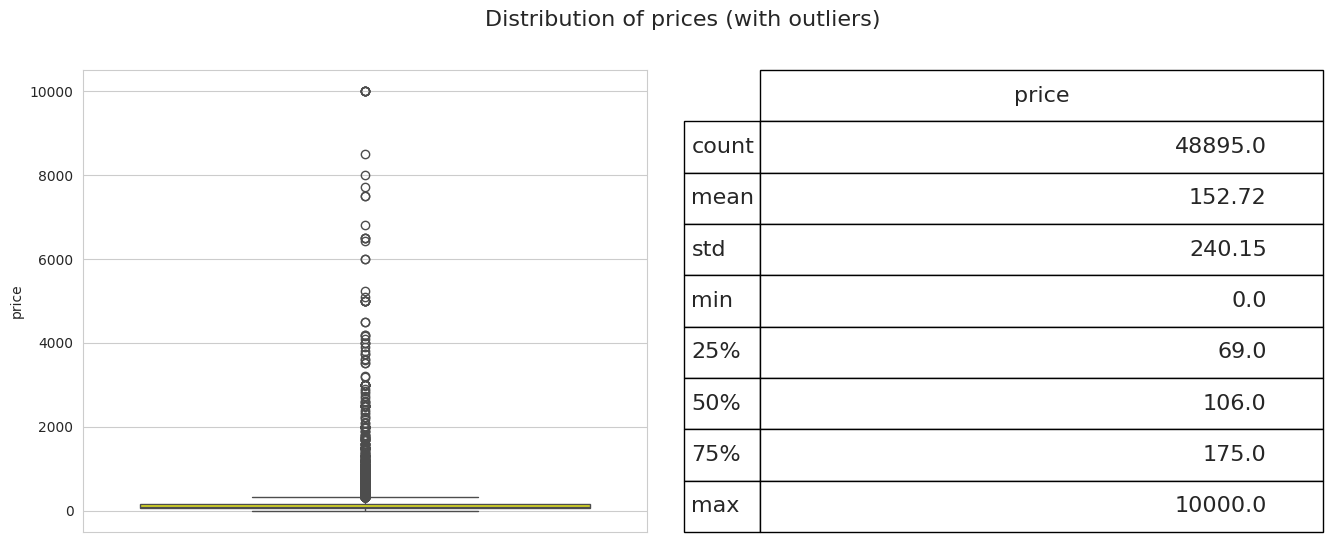

/tmp/ipykernel_12916/3189095013.py:32: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(airbnb['price'],color='orange')


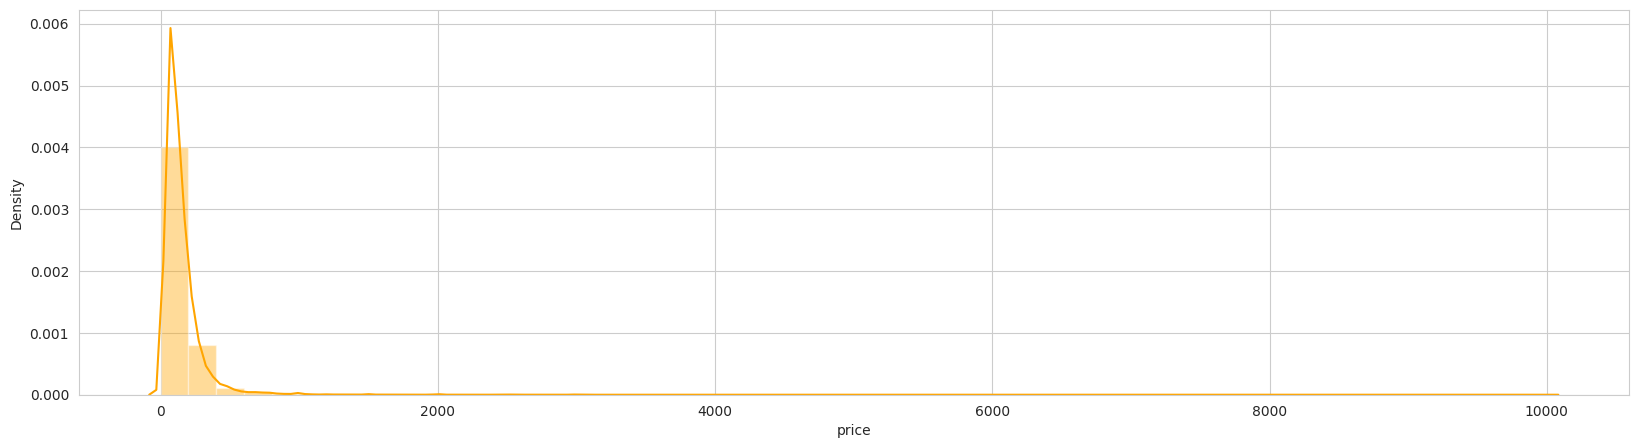

Skewness: 19.118938995046033
Kurtosis: 585.6728788988286


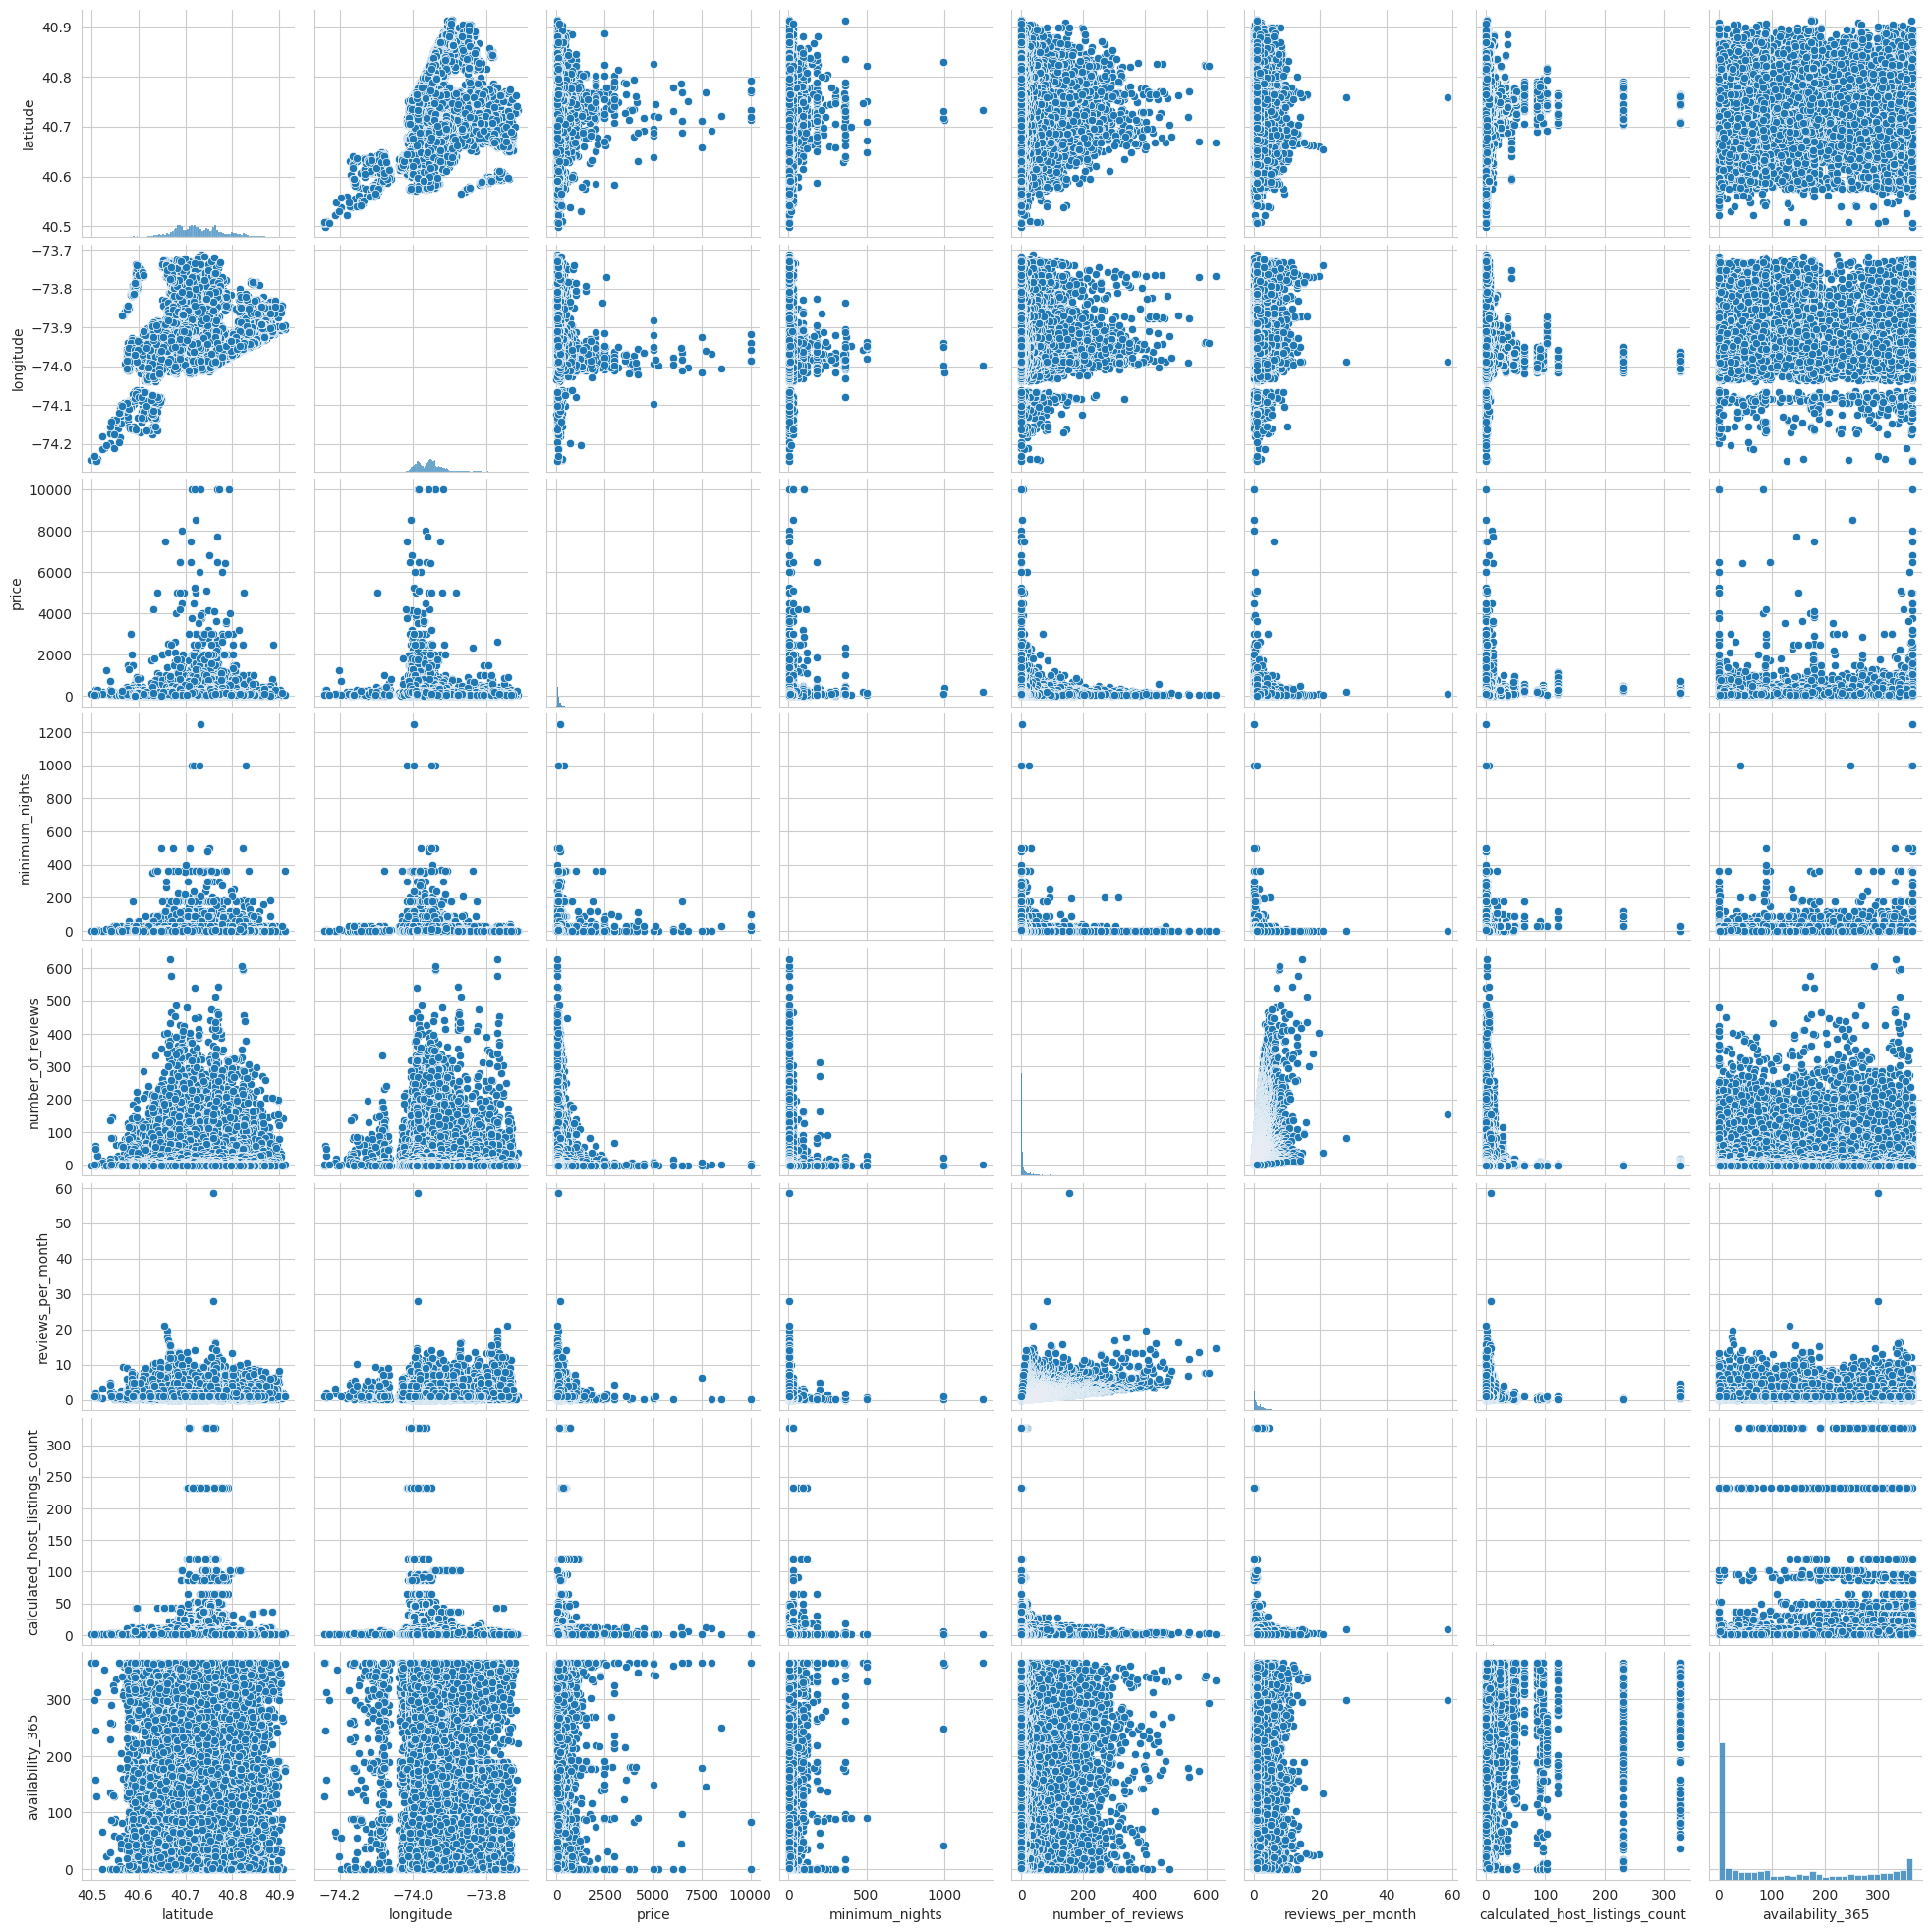

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   last_review                     38843 non-null  object 
 9   reviews_per_month               38843 non-null  float64
 10  calculated_host_listings_count  48895 non-null  int64  
 11  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), object(

In [24]:


#print correlation
# 'neighbourhood', 'neighbourhood_group', 'room_type', --> categorical columns
top = 8
corr = airbnb[['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_365']].corr(method='spearman')
top8 = abs(corr.nlargest(top,'price')['price']).index
corr_top8 = airbnb[top8].corr(method='spearman')
plt.figure(figsize=(15,8))
ax = sns.heatmap(corr_top8, annot=True, linewidths=0.1, fmt='.2f', cmap='Reds', annot_kws={'size':12})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.savefig('corr.png')

# print details about target column

fig = plt.figure(figsize=(16,6))

ax1 = fig.add_subplot(121)
# ax1.boxplot(data['price'])
sns.boxplot(y = airbnb['price'], ax=ax1, color='yellow')
describe = airbnb['price'].describe().to_frame().round(2)

ax2 = fig.add_subplot(122)
ax2.axis('off')
font_size = 16
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of prices (with outliers)', fontsize=16)
plt.show()

fig = plt.figure(figsize=(20,5))
sns.distplot(airbnb['price'],color='orange')
plt.show()

print('Skewness: {}'.format(airbnb['price'].skew()))
#Skewness - measure of symmetry/assymetry of distribution. If the distribution is perfectly symmetrical, 
#the value of skewness is equal to 0. If skewness > 0 : positive, if skewness < 0 : negative
print('Kurtosis: {}'.format(airbnb['price'].kurt()))
#Kurtosis - measure of flattening distribution of a feature. 

#pairplot

sns.pairplot(airbnb)
plt.show()

print(airbnb.info(memory_usage="deep"))  # Check memory usage


DATA Cleaning

/tmp/ipykernel_12916/4263081538.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  missing_plot = sns.barplot(x=missing_values.index[0:2],y=missing_values[0:2],palette='bright')
/tmp/ipykernel_12916/4263081538.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  missing_plot.set_xticklabels(missing_plot.get_xticklabels(),rotation=90)


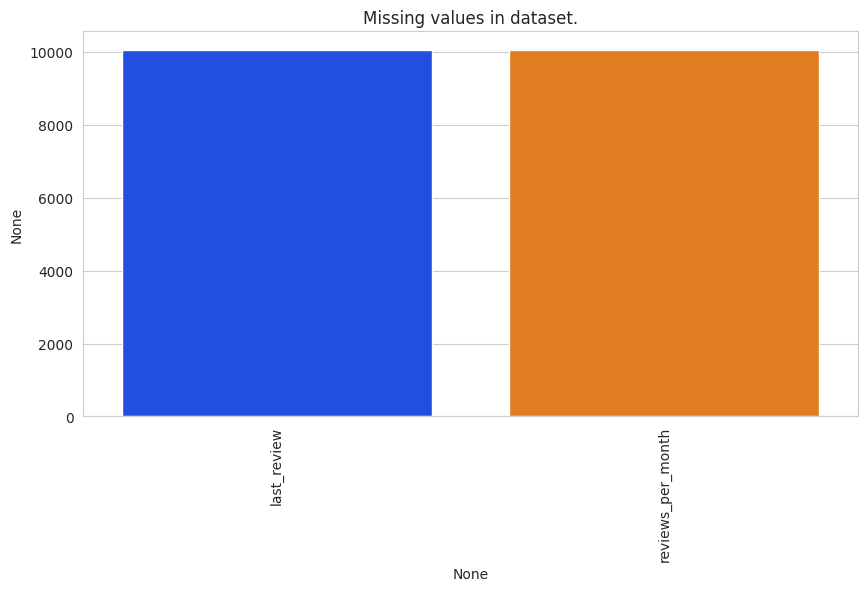

In [25]:
# Dealing with null values
missing_values = airbnb.isnull().sum().sort_values(ascending=False)
percentage_missing_values = round((airbnb.isnull().sum()/airbnb.isnull().sum().sum()).sort_values(ascending=False),3)
null_in_data = pd.concat([missing_values, percentage_missing_values],keys=['Missing values','Percentage'],axis=1)
null_in_data.head(2)

plt.figure(figsize=(10,5))
missing_plot = sns.barplot(x=missing_values.index[0:2],y=missing_values[0:2],palette='bright')
missing_plot.set_xticklabels(missing_plot.get_xticklabels(),rotation=90)
plt.title('Missing values in dataset.')
plt.show()

In [26]:
airbnb['last_review'].head()
airbnb['reviews_per_month'].head()

airbnb['reviews_per_month'].fillna(value=0, inplace=True)
airbnb.drop('last_review',axis=1,inplace=True)

airbnb.isnull().sum().sum()

/tmp/ipykernel_12916/3776036185.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  airbnb['reviews_per_month'].fillna(value=0, inplace=True)


0

Outliers

In [27]:
def tukey_outliers(df, column):
  Q1 = np.percentile(df[column], 25)
  Q3 = np.percentile(df[column], 75)
  IQR = Q3 - Q1
  outlier_step = 1.5 * IQR
  outliers_index = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step)].index
  return outliers_index

outliers_index = tukey_outliers(airbnb,'price')
airbnb.drop(outliers_index, inplace=True)
airbnb.reset_index(drop=True, inplace=True)


Zero Values in price


In [28]:
airbnb[airbnb['price']==0].head()
print('Together we have {} listings with price equal to 0.'.format(len(airbnb[airbnb['price']==0])))
airbnb.drop(airbnb[airbnb['price']==0].index, inplace=True)
airbnb.reset_index(drop=True, inplace=True)

Together we have 11 listings with price equal to 0.


Maps

In [29]:
NY_map = folium.Map([40.730610,-73.935242],zoom_start=10)
HeatMap(airbnb[['latitude','longitude']],radius=10).add_to(NY_map)
display(NY_map)

Data Prep

In [32]:
# 3. Encoding categorical variables (example: neighborhood_group)
label_encoder = LabelEncoder()
airbnb['neighbourhood_group'] = label_encoder.fit_transform(airbnb['neighbourhood_group'])

# 4. Feature selection
# Selecting columns that are useful for prediction
features = ['neighbourhood_group', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_365']
target = 'price'

# Encode categorical variables in 'room_type'
airbnb['room_type'] = label_encoder.fit_transform(airbnb['room_type'])


In [33]:
# Split the data into features (X) and target (y)
X_airbnb = airbnb[features]
y_airbnb = airbnb[target]


print(X_airbnb.shape)
print(y_airbnb.shape)
# Split the data
X_train_airbnb, X_test_airbnb, y_train_airbnb, y_test_airbnb = train_test_split(X_airbnb, y_airbnb, test_size=0.2, random_state=42)

(45912, 9)
(45912,)


In [36]:
# Airbnb Dataset

xgb_reg_airbnb = xgb.XGBRegressor(objective='reg:squarederror')
xgb_reg_airbnb.fit(X_train_airbnb, y_train_airbnb)
y_pred_airbnb = xgb_reg_airbnb.predict(X_test_airbnb)
rmse_airbnb = np.sqrt(mean_squared_error(y_test_airbnb, y_pred_airbnb))
print(f'Airbnb RMSE: {rmse_airbnb}')

# Airbnb RMSE: 0.7924941573544363


Airbnb RMSE: 0.7924941573544363


In [37]:
import psutil

# Get memory usage in MB
mem = psutil.virtual_memory()
print(f"Total Memory: {mem.total / (1024**3):.2f} GB")
print(f"Used Memory: {mem.used / (1024**3):.2f} GB")
print(f"Available Memory: {mem.available / (1024**3):.2f} GB")
print(f"Memory Usage Percentage: {mem.percent}%")


Total Memory: 15.32 GB
Used Memory: 1.13 GB
Available Memory: 13.93 GB
Memory Usage Percentage: 9.1%


In [35]:
import torch

if torch.cuda.is_available():
    print(torch.cuda.memory_summary())
else:
    print("CUDA GPU not available!")


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [ ]:
import gc
gc.collect()  # Force garbage collection
